<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/openai/Fine_tune_OpenAI_with_Weights_and_Biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{openai-finetune-gpt3} -->

<img src="https://wandb.me/logo-im-png" width="400" alt="Weights & Biases" />

<!--- @wandbcode{openai-finetune-gpt35} -->

# Fine-tune ChatGPT-3.5 and GPT-4 with Weights & Biases

If you use OpenAI's API to [fine-tune ChatGPT-3.5](https://platform.openai.com/docs/guides/fine-tuning), you can now use the `WandbLogger` integration to track experiments, models, and datasets in your central dashboard with just two lines of code:

```
from wandb.integration.openai.fine_tuning import WandbLogger

# Your fine-tuning logic

WandbLogger.sync(id=fine_tune_job_id)
```

See the [OpenAI section](https://wandb.me/openai-docs) in the Weights & Biases documentation for full details of the integration.

In [1]:
!pip install -Uq wandb openai tiktoken datasets tenacity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.4/327.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In this colab notebook, we will be finetuning GPT 3.5 model on the [LegalBench](https://hazyresearch.stanford.edu/legalbench/) dataset. The notebook will show how to prepare and validate the dataset, upload it to OpenAI and setup a fine-tune job. Finally, the notebook shows how to use the `WandbLogger`.

### Imports and initial set-up

In [2]:
from openai import OpenAI
import wandb

import os
import glob
import json
import random
import tiktoken
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
from tenacity import retry, stop_after_attempt, wait_fixed

Initialize the OpenAI client

You can add the api key to your environment variable by doing `os.environ['OPENAI_API_KEY'] = "sk-...."`.

In [3]:
# Uncomment the line below and set your OpenAI API Key.
# os.environ['OPENAI_API_KEY'] = "sk-...."
from dotenv import load_dotenv
load_dotenv()

client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

Import the `WandbLogger`

In [4]:
from wandb.integration.openai.fine_tuning import WandbLogger

WANDB_PROJECT = "OpenAI-Fine-Tune"

### Dataset Preparation

We download a dataset from [LegalBench](https://hazyresearch.stanford.edu/legalbench/), a project to curate tasks for evaluating legal reasoning, specifically the [Contract NLI Explicit Identification task](https://github.com/HazyResearch/legalbench/tree/main/tasks/contract_nli_explicit_identification).

This comprises of a total of 117 examples, from which we will create our own train and test datasets

In [5]:
from datasets import load_dataset

# Download the data, merge into a single dataset and shuffle
dataset = load_dataset("nguha/legalbench", "contract_nli_explicit_identification")

data = []
for d in dataset["train"]:
  data.append(d)

for d in dataset["test"]:
  data.append(d)

random.shuffle(data)

for idx, d in enumerate(data):
  d["new_index"] = idx

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for nguha/legalbench contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/nguha/legalbench.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/8 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/109 [00:00<?, ? examples/s]

Let's look at a few samples.

In [6]:
len(data), data[0:2]

(117,
 [{'answer': 'No',
   'index': '99',
   'text': 'YOU AGREE WITH US: G) to destroy immediately on our written request all Confidential Information in your possession including any copies made (save where we are required pursuant to some law or enactment or regulation or the rules of any Stock Exchange to retain originals or copies of any of the Confidential Information). ',
   'document_name': 'Business-Sale-Non-Disclosure-Agreement.pdf',
   'new_index': 0},
  {'answer': 'No',
   'index': '22',
   'text': 'Failure to mark any of the Confidential Information as confidential or proprietary shall not affect its status as Confidential Information.  ',
   'document_name': 'Attachment B - Intent to Propose and Non-Disclosure Agreement.pdf',
   'new_index': 1}])

### Format our Data for Chat Completion Models
We modify the `base_prompt` from the LegalBench task to make it a zero-shot prompt, as we are training the model instead of using few-shot prompting

In [7]:
base_prompt_zero_shot = "Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`"

We now split it into training/validation dataset, lets train on 30 samples and test on the remainder


In [8]:
n_train = 30
n_test = len(data) - n_train

In [9]:
train_messages = []
test_messages = []

for d in data:
  prompts = []
  prompts.append({"role": "system", "content": base_prompt_zero_shot})
  prompts.append({"role": "user", "content": d["text"]})
  prompts.append({"role": "assistant", "content": d["answer"]})

  if int(d["new_index"]) < n_train:
    train_messages.append({'messages': prompts})
  else:
    test_messages.append({'messages': prompts})

len(train_messages), len(test_messages), n_test, train_messages[5]

(30,
 87,
 87,
 {'messages': [{'role': 'system',
    'content': 'Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`'},
   {'role': 'user',
    'content': 'Notwithstanding the foregoing,  (a) the Receiving Party’s legal department and/or outside counsel may keep one copy of the Confidential Information (in electronic or paper form) and, with respect to the Receiving Party’s Representatives who are accounting firms, such firms may keep one copy of the Confidential Information, in each case, if required to comply with applicable law or regulation and  (b) the Receiving Party and its Representatives may retain Confidential Information to the extent it is “backed-up” on its or their (as the case may be) electronic information management and communications systems or servers, is not available to an end user and cannot be expunged without considerable effort; provided, that any such informatio

### Save the data to Weights & Biases

Save the data in a train and test file first

In [10]:
train_file_path = 'encoded_train_data.jsonl'
with open(train_file_path, 'w') as file:
    for item in train_messages:
        line = json.dumps(item)
        file.write(line + '\n')

test_file_path = 'encoded_test_data.jsonl'
with open(test_file_path, 'w') as file:
    for item in test_messages:
        line = json.dumps(item)
        file.write(line + '\n')

### Run the OpenAI data validation script
Next, we validate that our training data is in the correct format using a script from the [OpenAI fine-tuning documentation](https://platform.openai.com/docs/guides/fine-tuning/)

In [11]:
# Next, we specify the data path and open the JSONL file

def openai_validate_data(dataset_path):
  data_path = dataset_path

  # Load dataset
  with open(data_path) as f:
      dataset = [json.loads(line) for line in f]

  # We can inspect the data quickly by checking the number of examples and the first item

  # Initial dataset stats
  print("Num examples:", len(dataset))
  print("First example:")
  for message in dataset[0]["messages"]:
      print(message)

  # Now that we have a sense of the data, we need to go through all the different examples and check to make sure the formatting is correct and matches the Chat completions message structure

  # Format error checks
  format_errors = defaultdict(int)

  for ex in dataset:
      if not isinstance(ex, dict):
          format_errors["data_type"] += 1
          continue

      messages = ex.get("messages", None)
      if not messages:
          format_errors["missing_messages_list"] += 1
          continue

      for message in messages:
          if "role" not in message or "content" not in message:
              format_errors["message_missing_key"] += 1

          if any(k not in ("role", "content", "name") for k in message):
              format_errors["message_unrecognized_key"] += 1

          if message.get("role", None) not in ("system", "user", "assistant"):
              format_errors["unrecognized_role"] += 1

          content = message.get("content", None)
          if not content or not isinstance(content, str):
              format_errors["missing_content"] += 1

      if not any(message.get("role", None) == "assistant" for message in messages):
          format_errors["example_missing_assistant_message"] += 1

  if format_errors:
      print("Found errors:")
      for k, v in format_errors.items():
          print(f"{k}: {v}")
  else:
      print("No errors found")

  # Beyond the structure of the message, we also need to ensure that the length does not exceed the 4096 token limit.

  # Token counting functions
  encoding = tiktoken.get_encoding("cl100k_base")

  # not exact!
  # simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
  def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
      num_tokens = 0
      for message in messages:
          num_tokens += tokens_per_message
          for key, value in message.items():
              num_tokens += len(encoding.encode(value))
              if key == "name":
                  num_tokens += tokens_per_name
      num_tokens += 3
      return num_tokens

  def num_assistant_tokens_from_messages(messages):
      num_tokens = 0
      for message in messages:
          if message["role"] == "assistant":
              num_tokens += len(encoding.encode(message["content"]))
      return num_tokens

  def print_distribution(values, name):
      print(f"\n#### Distribution of {name}:")
      print(f"min / max: {min(values)}, {max(values)}")
      print(f"mean / median: {np.mean(values)}, {np.median(values)}")
      print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

  # Last, we can look at the results of the different formatting operations before proceeding with creating a fine-tuning job:

  # Warnings and tokens counts
  n_missing_system = 0
  n_missing_user = 0
  n_messages = []
  convo_lens = []
  assistant_message_lens = []

  for ex in dataset:
      messages = ex["messages"]
      if not any(message["role"] == "system" for message in messages):
          n_missing_system += 1
      if not any(message["role"] == "user" for message in messages):
          n_missing_user += 1
      n_messages.append(len(messages))
      convo_lens.append(num_tokens_from_messages(messages))
      assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

  print("Num examples missing system message:", n_missing_system)
  print("Num examples missing user message:", n_missing_user)
  print_distribution(n_messages, "num_messages_per_example")
  print_distribution(convo_lens, "num_total_tokens_per_example")
  print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
  n_too_long = sum(l > 4096 for l in convo_lens)
  print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

  # Pricing and default n_epochs estimate
  MAX_TOKENS_PER_EXAMPLE = 4096

  MIN_TARGET_EXAMPLES = 100
  MAX_TARGET_EXAMPLES = 25000
  TARGET_EPOCHS = 3
  MIN_EPOCHS = 1
  MAX_EPOCHS = 25

  n_epochs = TARGET_EPOCHS
  n_train_examples = len(dataset)
  if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
      n_epochs = min(MAX_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
  elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
      n_epochs = max(MIN_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

  n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
  print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
  print(f"By default, you'll train for {n_epochs} epochs on this dataset")
  print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
  print("See pricing page to estimate total costs")

Validate train data

In [12]:
openai_validate_data(train_file_path)

Num examples: 30
First example:
{'role': 'system', 'content': 'Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`'}
{'role': 'user', 'content': 'YOU AGREE WITH US: G) to destroy immediately on our written request all Confidential Information in your possession including any copies made (save where we are required pursuant to some law or enactment or regulation or the rules of any Stock Exchange to retain originals or copies of any of the Confidential Information). '}
{'role': 'assistant', 'content': 'No'}
No errors found
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 68, 319
mean / median: 144.33333333333334, 137.5
p5 / p95: 82.2, 212.0

#### Distribution of num_assistant_tokens_per_example:

Validate test data

In [13]:
openai_validate_data(test_file_path)

Num examples: 87
First example:
{'role': 'system', 'content': 'Identify if the clause provides that all Confidential Information shall be expressly identified by the Disclosing Party. Answer with only `Yes` or `No`'}
{'role': 'user', 'content': 'The Recipient agrees to destroy all documents, memoranda, notes and other writings whatsoever prepared by the Recipient or its employees or representatives based on the information contained in the Confidential Information (except for references or summaries appearing in minutes or corporate records). '}
{'role': 'assistant', 'content': 'No'}
No errors found
Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 61, 404
mean / median: 136.94252873563218, 114.0
p5 / p95: 82.6, 217.20000000000005

#### Distribution of num_assistant_tokens_per_example:
min / m

## Upload the training and validation data to OpenAI

We will first upload the data to OpenAI. This might take a few minutes depending on the size of your dataset.

In [14]:
openai_train_file_info = client.files.create(
    file=open(train_file_path, "rb"), purpose="fine-tune"
)

openai_valid_file_info = client.files.create(
    file=open(test_file_path, "rb"), purpose="fine-tune"
)

In [15]:
openai_train_file_info

FileObject(id='file-UtXYAQ9q1u4pzHDopLuvwNZE', bytes=24143, created_at=1719240975, filename='encoded_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [16]:
openai_valid_file_info

FileObject(id='file-PH8GAUptDJ7rguWGAHnfAhEq', bytes=67000, created_at=1719240976, filename='encoded_test_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

> Notice the unique ids for both training and validation data. OpenAI uses these ids to access the uploaded data to fine-tune GPT 3.5 on.

# Train the model and log to Weights & Biases

Let's define our ChatGPT-3.5 fine-tuning hyper-parameters.

In [17]:
model = 'gpt-3.5-turbo'
n_epochs = 3

In [18]:
openai_ft_job_info = client.fine_tuning.jobs.create(
    training_file=openai_train_file_info.id,
    model=model,
    hyperparameters={"n_epochs": n_epochs},
    validation_file=openai_valid_file_info.id
)

ft_job_id = openai_ft_job_info.id


> this takes around 5 minutes to train.

### Start Weight & Biases Sync
Calling `WandbLogger.sync` will start polling OpenAI for the fine-tuning job results and log them when they are retrieved, see the [docs](https://docs.wandb.ai/guides/integrations/openai) for how to modify this behaviour

In [20]:
# Log to Weights and Biases
WandbLogger.sync(fine_tune_job_id=ft_job_id, project=WANDB_PROJECT, openai_client=client)

wandb: Retrieving fine-tune job...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: stephen4sheng (lazycodedoggy). Use `wandb login --relogin` to force relogin


wandb: Waiting for the OpenAI fine-tuning job to finish training...
wandb: To avoid blocking, you can call `WandbLogger.sync` with `wait_for_job_success=False` after OpenAI training completes.
wandb: Fine-tuning finished, logging metrics, model metadata, and run metadata to Weights & Biases
wandb: Logging training/validation files...


fine_tuned_model,ft:gpt-3.5-turbo-012...
status,succeeded


'🎉 wandb sync completed successfully'

**Thats it!**

Now your model is training on OpenAI's machines.

Logging the fine-tuning job to W&B is straight forward. The integration will automatically log the following to W&B:

- training and validation metrics (if validation data is provided)
- log the training and validation data as W&B Tables for storage and versioning
- log the fine-tuned model's metadata.

The integration automatically creates the DAG lineage between the data and the model.

> You can call the `WandbLogger` with the job id. The cell will keep running till the fine-tuning job is not complete. Once the job's status is `succeeded`, the `WandbLogger` will log metrics and data to W&B. This way you don't have to wait for the fine-tune job to be completed to call `WandbLogger.sync`.

Calling `WandbLogger.sync` without any id will log all un-synced fine-tuned jobs to W&B

See the [OpenAI section](https://wandb.me/openai-docs) in the Weights & Biases documentation for full details of the integration

The fine-tuning job is now successfully synced to Weights and Biases. Click on the URL above to open the [W&B run page](https://docs.wandb.ai/guides/app/pages/run-page). The following will be logged to W&B:

#### Training and validation metrics

![image.png](https://github.com/wandb/examples/blob/master/colabs/openai/assets/metrics.png?raw=1)

#### Training and validation data as W&B Tables

![image.png](https://github.com/wandb/examples/blob/master/colabs/openai/assets/datatable.png?raw=1)

#### The data and model artifacts for version control (go to the overview tab)

![image.png](https://github.com/wandb/examples/blob/master/colabs/openai/assets/artifacts.png?raw=1)

#### The configuration and hyperparameters (go to the overview tab)

![image.png](https://github.com/wandb/examples/blob/master/colabs/openai/assets/configs.png?raw=1)

#### The data and model DAG

![image.png](https://github.com/wandb/examples/blob/master/colabs/openai/assets/dag.png?raw=1)

## Run evalution and log the results

The best way to evaluate a generative model is to explore sample predictions from your evaluation set.

Let's generate a few inference samples and log them to W&B and see how the performance compares to a baseline ChatGPT-3.5 model

We will be evaluating using the validation dataset. In the overview tab of the run page, find the "validation_files" in the Artifact Inputs section. Clicking on it will take you to the artifacts page. Copy the artifact URI (full name) as shown in the image below.

![image](https://github.com/wandb/examples/blob/master/colabs/openai/assets/select_artifact_uri.png?raw=1)

In [21]:
run = wandb.init(
    project=WANDB_PROJECT,
    job_type='eval'
)

VALIDATION_FILE_ARTIFACT_URI = 'lazycodedoggy/OpenAI-Fine-Tune/valid-file-PH8GAUptDJ7rguWGAHnfAhEq:v0' # REPLACE THIS WITH YOUR OWN ARTIFACT URI

artifact_valid = run.use_artifact(
    VALIDATION_FILE_ARTIFACT_URI,
    type='validation_files'
)

The code snippet below, download the logged validation data and prepare a pandas dataframe from it.

In [22]:
artifact_valid_path = artifact_valid.download()
print("Downloaded the validation data at: ", artifact_valid_path)

validation_file = glob.glob(f"{artifact_valid_path}/*.table.json")[0]
with open(validation_file, 'r') as file:
    data = json.load(file)

validation_df = pd.DataFrame(columns=data["columns"], data=data["data"])

print(f"There are {len(validation_df)} validation examples")
run.config.update({"num_validation_samples":len(validation_df)})

validation_df.head()

wandb:   2 of 2 files downloaded.  


Downloaded the validation data at:  /content/artifacts/valid-file-PH8GAUptDJ7rguWGAHnfAhEq:v0
There are 87 validation examples


,role: system,role: user,role: assistant
0,Identify if the clause provides that all Confi...,"The Recipient agrees to destroy all documents,...",No
1,Identify if the clause provides that all Confi...,The term “Confidential Information” means any ...,No
2,Identify if the clause provides that all Confi...,2.1. Either party agrees that it shall ensure ...,No
3,Identify if the clause provides that all Confi...,"Upon the Company's request, we shall promptly ...",No
4,Identify if the clause provides that all Confi...,"The term ""Confidential Information"", as used h...",Yes


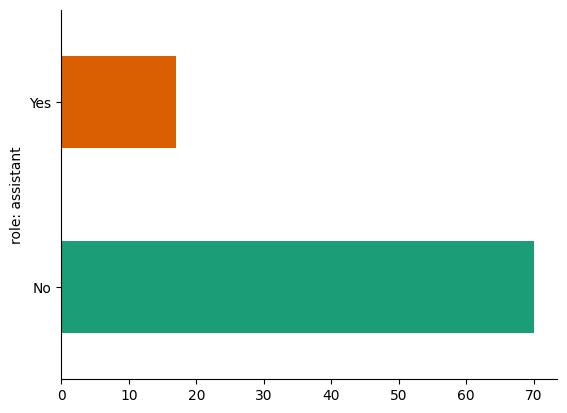

In [23]:
# @title role: assistant

from matplotlib import pyplot as plt
import seaborn as sns
validation_df.groupby('role: assistant').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

We will need to package the data in the dataframe in the format acceptable by GPT 3.5. The format is:

```
{"messages": [{"role": "system", "content": "some system prompt"}, {"role": "user", "content": "some user prompt"}, {"role": "assistant", "content": "completion text"}]}
```

For evaluation we don't need to pack the `{"role": "assistant", "content": "completition text"}` in `messages` as this is meant to be generated by GPT 3.5.

In [24]:
def eval_data_format(row):
    role_system_content = row["role: system"]
    role_system_dict = {"role": "system", "content": role_system_content}

    role_user_content = row["role: user"]
    role_user_dict = {"role": "user", "content": role_user_content}

    return [role_system_dict, role_user_dict]

validation_df["messages"] = validation_df.apply(lambda row: eval_data_format(row), axis=1)
validation_df.head()

,role: system,role: user,role: assistant,messages
0,Identify if the clause provides that all Confi...,"The Recipient agrees to destroy all documents,...",No,"[{'role': 'system', 'content': 'Identify if th..."
1,Identify if the clause provides that all Confi...,The term “Confidential Information” means any ...,No,"[{'role': 'system', 'content': 'Identify if th..."
2,Identify if the clause provides that all Confi...,2.1. Either party agrees that it shall ensure ...,No,"[{'role': 'system', 'content': 'Identify if th..."
3,Identify if the clause provides that all Confi...,"Upon the Company's request, we shall promptly ...",No,"[{'role': 'system', 'content': 'Identify if th..."
4,Identify if the clause provides that all Confi...,"The term ""Confidential Information"", as used h...",Yes,"[{'role': 'system', 'content': 'Identify if th..."


### Run evaluation on the Fine-Tuned Model

Next up we will get the fine-tuned model's id from the logged `model_metadata`. In the overview tab of the run page, find the "model" in the Artifact Outputs section. Clicking on it will take you to the artifacts page. Copy the artifact URI (full name) as shown in the image below.

![image](https://github.com/wandb/examples/blob/master/colabs/openai/assets/select_model_artifact.png?raw=1)

In [25]:
MODEL_ARTIFACT_URI = 'lazycodedoggy/OpenAI-Fine-Tune/model-metadata:v0' # REPLACE THIS WITH YOUR OWN ARTIFACT URI

model_artifact = run.use_artifact(
    MODEL_ARTIFACT_URI,
    type='model'
)

In [26]:
model_metadata_path = model_artifact.download()
print("Downloaded the validation data at: ", model_metadata_path)

model_metadata_file = glob.glob(f"{model_metadata_path}/*.json")[0]
with open(model_metadata_file, 'r') as file:
    model_metadata = json.load(file)

model_metadata

wandb:   1 of 1 files downloaded.  


Downloaded the validation data at:  /content/artifacts/model-metadata:v0


{'id': 'ftjob-NXKRWuTTQudq1y3kkXxb0Rdn',
 'created_at': 1719241125,
 'error': "{'code': None, 'message': None, 'param': None}",
 'fine_tuned_model': 'ft:gpt-3.5-turbo-0125:personal::9dfXjdUm',
 'finished_at': 1719241510,
 'hyperparameters': "{'n_epochs': 3, 'batch_size': 1, 'learning_rate_multiplier': 2}",
 'model': 'gpt-3.5-turbo-0125',
 'object': 'fine_tuning.job',
 'organization_id': 'org-CRoAd4fIPb49u2eQFSMuLpEj',
 'result_files': "['file-Q6QgS9eV3J6wW5QARdzJSIA4']",
 'seed': 1008632995,
 'status': 'succeeded',
 'trained_tokens': 12810,
 'training_file': 'file-UtXYAQ9q1u4pzHDopLuvwNZE',
 'validation_file': 'file-PH8GAUptDJ7rguWGAHnfAhEq',
 'estimated_finish': 'None',
 'integrations': '[]',
 'user_provided_suffix': 'None'}

In [27]:
fine_tuned_model = model_metadata["fine_tuned_model"]
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

Run evaluation and log results to W&B

In [28]:
prediction_table = wandb.Table(columns=['messages', 'completion', 'target'])

eval_data = []

for idx, row in tqdm(validation_df.iterrows()):
    messages = row.messages
    target = row["role: assistant"]

    res = client.chat.completions.create(model=fine_tuned_model, messages=messages, max_tokens=10)
    completion = res.choices[0].message.content

    eval_data.append([messages, completion, target])
    prediction_table.add_data(messages[1]['content'], completion, target)

wandb.log({'predictions': prediction_table})

0it [00:00, ?it/s]

Calculate the accuracy of the fine-tuned model and log to W&B



In [29]:
correct = 0
for e in eval_data:
  if e[1].lower() == e[2].lower():
    correct+=1

accuracy = correct / len(eval_data)

print(f"Accuracy is {accuracy}")
wandb.log({"eval/accuracy": accuracy})
wandb.summary["eval/accuracy"] = accuracy

Accuracy is 0.9080459770114943


### Run evaluation on a Baseline model for comparison
Lets compare our model to the baseline model, `gpt-3.5-turbo`

In [ ]:
baseline_prediction_table = wandb.Table(columns=['messages', 'completion', 'target'])

baseline_eval_data = []

for idx, row in tqdm(validation_df.iterrows()):
    messages = row.messages
    target = row["role: assistant"]

    res = client.chat.completions.create(model="gpt-3.5-turbo", messages=messages, max_tokens=10)
    completion = res.choices[0].message.content

    baseline_eval_data.append([messages, completion, target])
    baseline_prediction_table.add_data(messages[1]['content'], completion, target)

wandb.log({'baseline_predictions': baseline_prediction_table})

Calculate the accuracy of the fine-tuned model and log to W&B

In [ ]:
baseline_correct = 0
for e in baseline_eval_data:
  if e[1].lower() == e[2].lower():
    baseline_correct+=1

baseline_accuracy = baseline_correct / len(baseline_eval_data)
print(f"Baseline Accurcy is: {baseline_accuracy}")
wandb.log({"eval/baseline_accuracy": baseline_accuracy})
wandb.summary["eval/baseline_accuracy"] =  baseline_accuracy

In [30]:
wandb.finish()

eval/accuracy,▁
eval/accuracy,0.90805


And thats it! In this example we have prepared our data, logged it to Weights & Biases, fine-tuned an OpenAI model using that data, logged the results to Weights & Biases and then run evaluation on the fine-tuned model.

From here you can start to train on larger or more complex tasks, or else explore other ways to modify ChatGPT-3.5 such as giving it a different tone and style or response.


# Resources

* [OpenAI Fine-Tuning Guide](https://platform.openai.com/docs/guides/fine-tuning)
* [W&B Integration with OpenAI API Documentation](https://wandb.me/openai-docs)